In [3]:
import numpy as np

import sys
sys.path.append('../src')  
from evaluation import simple_evaluate_model, evaluate_colorization_quality
from data_utils import (
    get_image_paths,
    load_image,
    load_grayscale_image,
    normalize_for_vgg
)
from model import StyleColorizer, VGGFeatureExtractor
import torch
import matplotlib.pyplot as plt
import os

print("Setting up evaluation...")

# Load trained model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = StyleColorizer().to(device)
try:
    model.load_state_dict(torch.load(
        '../models/baseline_model.pth',
        map_location=device
    ))
    print("Model loaded successfully!")
except Exception as e:
    print(f"Error loading model: {e}")
    print("Make sure you've trained and saved the model first.")

vgg_extractor = VGGFeatureExtractor(
    ['21'], ['0','5','10','19','28']
).to(device)
print("VGG extractor loaded!")


Setting up evaluation...
Model loaded successfully!
VGG extractor loaded!


Found 1 content images
Found 8 style images
Testing with:
  Content: sample.png
  Style:   Monet.jpg
AdaIN: style a_std 2.335, b_std 1.750
AdaIN: style a_mean 0.484, b_mean 0.378

= EVALUATION RESULTS =
content_fidelity: 0.2610
style_effectiveness: 0.9998
color_diversity: 12.6639


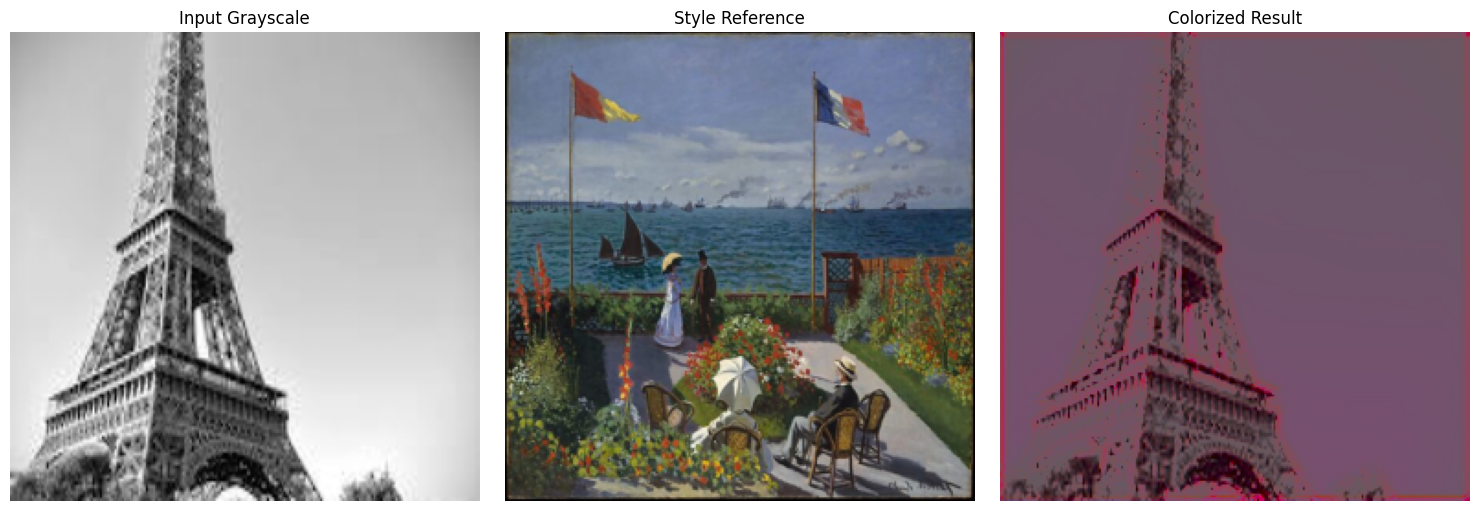

In [4]:
# Get available files
content_files = get_image_paths('../data/content/')
style_files   = get_image_paths('../data/styles/')
print(f"Found {len(content_files)} content images")
print(f"Found {len(style_files)} style images")

if not content_files or not style_files:
    print("Please add images to data/content/ and data/styles/")
else:
    # Pick the first content and style paths
    content_path = content_files[0]
    style_path   = style_files[0]
    print("Testing with:")
    print(f"  Content: {os.path.basename(content_path)}")
    print(f"  Style:   {os.path.basename(style_path)}")

    # Run evaluation
    rgb_result, metrics = simple_evaluate_model(
        model, vgg_extractor,
        content_path, style_path,
        device
    )

    print("\n= EVALUATION RESULTS =")
    for key, value in metrics.items():
        print(f"{key}: {value:.4f}")

    # Visualize inputs and result
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    gray_img = load_grayscale_image(content_path).squeeze().cpu().numpy()
    axes[0].imshow(gray_img, cmap='gray')
    axes[0].set_title('Input Grayscale')
    axes[0].axis('off')

    style_np = load_image(style_path).squeeze().permute(1,2,0).cpu().numpy()
    axes[1].imshow(style_np)
    axes[1].set_title('Style Reference')
    axes[1].axis('off')

    result_np = rgb_result.squeeze().permute(1,2,0).cpu().numpy()
    result_np = np.clip(result_np, 0, 1)
    axes[2].imshow(result_np)
    axes[2].set_title('Colorized Result')
    axes[2].axis('off')

    plt.tight_layout()
    plt.savefig('../results/evaluation_sample.png', dpi=150)
    plt.show()
